# Homework2 - Multi-class Weather Classification


Data sets are available in
https://drive.google.com/drive/folders/1UzH28Q8xki8_DMYdDgHxi40-CJ800Kaq

Read the README file in this folder for further instructions about data.

Project development

1) Solve the image classification problem in two modes: 
A) define a CNN and train it from scratch, 
B) apply transfer learning and fine tuning from a pre-trained model.
For training you can use any subset of the MWI dataset.

2) Evaluate the two models in a proper way. Discuss the best model and motivate the choice. Testing can be done either with cross-validation on MWI or with the SMART-I weather test set.

3) Write a report (about 10 pages) explaining all the work done: design and implementation choices, evaluation procedure and results. Reports must be individual.

4) Submit a set of images to be used to define a new test set.

5) Submit your best model (layout and weights)

IMPORTANT: when submitting new images for the new test set take care of copyright and privacy. Submit only images taken by yourself (not downloaded from web) and without faces or other personal information of any kind. By submitting these images, you also give permission to be used for non-commercial research and educational purposes and possibly to be added in the MWI dataset.


Submission procedure


Submit through classroom (e-mail submissions will not be accepted) the following files:

1) PDF file of the report (no other formats accepted),
2) ZIP file with the code (without data set),

3) ZIP file with new images subdivided in folders named exactly: HAZE, RAINY, SNOWY, SUNNY. 10 to 20 images possibly balanced, but it is not necessary to fill all the classes.

4) File containing the best model to be evaluated with the test set (more details on this final step will be given later).

Deadline: 15/12/2019 11:59 PM CET


NOTE: for exam bonus, only the PDF report (and possibly the code) will be considered. Contribution to the new test set and evaluation of best models (still mandatory) will be performed only for educational purposes.

# Imports

In [0]:
!pip install -U tensorflow-gpu numpy keras scikit-learn pandas matplotlib seaborn

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.17.4)
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.25.3)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.1.2)
Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [0]:
# ignoring useless warnings
import warnings

warnings.filterwarnings("ignore", ".*corrupt EXIF data.*", UserWarning)
warnings.filterwarnings("ignore", ".*", FutureWarning)
warnings.filterwarnings("ignore", ".*", DeprecationWarning)

# for data preprocessing and learning
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import optimizers
from keras import applications
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 

# for evaluating, plotting and saving the results
import os, random, shutil
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from sklearn.externals import joblib

sns.set_style("dark")

print("Tensorflow version:", tf.__version__)
print("GPU is available:", tf.test.is_gpu_available())

Using TensorFlow backend.


Tensorflow version: 2.0.0
GPU is available: True


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset

Loading the dataset.

In [0]:
main_folder = "./drive/My Drive/Colab Notebooks (1)/ML_HW2"
homework_folder = "./drive/My Drive/Colab Notebooks (1)/ML_HW2/andrea"
dataset_folder = main_folder + "/datasets"

In [0]:
dataset_path = dataset_folder + "/MWI-Dataset_4000"

## Random samples

Showing random samples of each class.

Sunny.

(1500, 2000, 3)


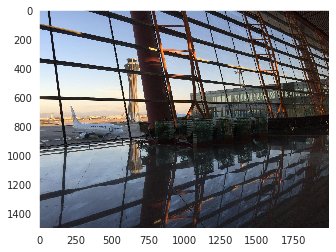

In [0]:
subfolder = dataset_path + "/SUNNY"

image = plt.imread(subfolder + "/" + random.choice(os.listdir(subfolder)))
print(image.shape)
plt.imshow(image)

Rainy.

(1227, 1936, 3)


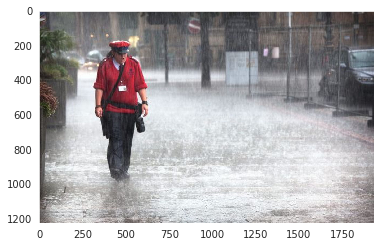

In [0]:
subfolder = dataset_path + "/RAINY"

image = plt.imread(subfolder + "/" + random.choice(os.listdir(subfolder)))
print(image.shape)
plt.imshow(image)

Snowy.

(960, 720, 3)


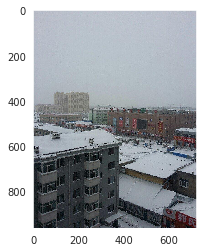

In [0]:
subfolder = dataset_path + "/SNOWY"

image = plt.imread(subfolder + "/" + random.choice(os.listdir(subfolder)))
print(image.shape)
plt.imshow(image)

Haze.

(1280, 720, 3)


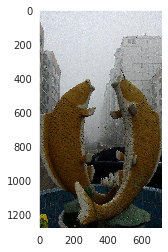

In [0]:
subfolder = dataset_path + "/HAZE"

image = plt.imread(subfolder + "/" + random.choice(os.listdir(subfolder)))
print(image.shape)
plt.imshow(image)

## Statistics

This subsection contains statistics on the dataset to better understand it.

### Image dimensions

Let's plot the distribution of the shapes of the images in the dataset.

Mean width: 853.102
Mean height: 727.8605
Mean dimensions ratio: 1.1720679992938208


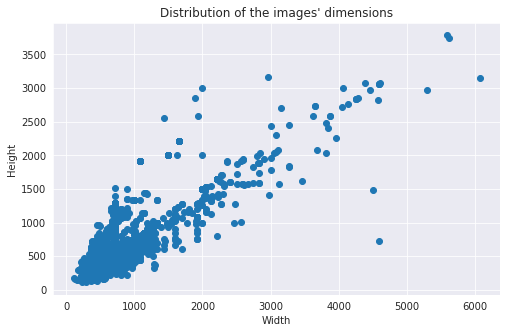

In [0]:
shapes = {"width":[], "height":[]}
for root_dir, subdirs, files in os.walk(dataset_path):
  for img in tqdm(files):
    img_path = os.path.join(root_dir, img)
    img = plt.imread(img_path)
    shapes["height"].append(img.shape[0])
    shapes["width"].append(img.shape[1])

shapes = pd.DataFrame(shapes)

print("Mean width:", shapes["width"].mean())
print("Mean height:", shapes["height"].mean())
print("Mean dimensions ratio:", (shapes["width"].mean()/shapes["height"].mean()))

plt.figure(figsize=(8,5))
plt.scatter(shapes["width"], shapes["height"])
plt.grid(True)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Distribution of the images' dimensions")
plt.show()

Mean width: 752.3655752478222
Mean height: 572.6674677080205
Mean dimensions ratio: 1.3137913670196861


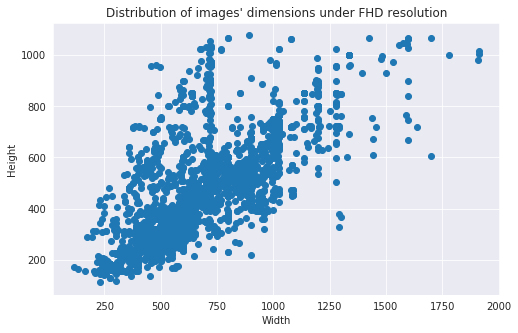

In [0]:
shapes_fhd = shapes[(shapes["width"] < 1920) & (shapes["height"] < 1080)]

print("Mean width:", shapes_fhd["width"].mean())
print("Mean height:", shapes_fhd["height"].mean())
print("Mean dimensions ratio:", (shapes_fhd["width"].mean()/shapes_fhd["height"].mean()))

plt.figure(figsize=(8,5))
plt.scatter(shapes_fhd["width"], shapes_fhd["height"])
plt.grid(True)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Distribution of images' dimensions under FHD resolution")
plt.show()

Keeping width = 224 as in MLEx10, using ratio of 1.31 for height, I get 172. So I will use shape (172, 224) as input shape for the imagedatagenerators and thus for the networks in this homework. This is done in the hope of having the generators keep the images untouched (except for rescaling and other specified transformations) as much as possible.

# Utilities

In this section there are several functions of utility.

In [0]:
def savemodel(models_dir,model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)


def loadmodel(models_dir,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    try:
        model = load_model(filename)
        print("\nModel loaded successfully from file %s\n" %filename)
    except OSError:    
        print("\nModel file %s not found!!!\n" %filename)
        model = None
    return model

def plot_image(i, predictions_array, true_label, img, class_names):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  true_label = np.argmax(true_label)

  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color,
                                fontsize = 13)


def plot_value_array(i, predictions_array, true_label, class_names):
  predictions_array, true_label = predictions_array[i], true_label[i]

  plt.grid(False)
  plt.xticks(range(4))
  plt.yticks([])
  thisplot = plt.bar(class_names, predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  true_label = np.argmax(true_label) #

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def plot_examples(X_test, y_test, y_pred, class_names):
  num_rows = 3
  num_cols = 3
  num_images = num_rows*num_cols
  plt.figure(figsize=(3*2*num_cols, 2*num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, y_pred, y_test, X_test, class_names)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_pred, y_test, class_names)
  plt.tight_layout()
  plt.show()

def plot_misclassified_examples(X_test, y_test, y_pred, class_names):
  misclassified_image_indices = []
  for i in range(len(y_test)):
    predicted_label = np.argmax(y_pred[i])
    true_label = np.argmax(y_test[i])
    if predicted_label != true_label:
      misclassified_image_indices.append(i)

  num_cols = min(3, len(misclassified_image_indices)+1)
  num_rows = min(3, len(misclassified_image_indices)//num_cols+1)
  num_images = num_rows*num_cols

  plt.figure(figsize=(3*2*num_cols, 2*num_rows))
  for i in range(num_images):
    try:
      image_index = misclassified_image_indices[i]
    except IndexError:
      break
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(image_index, y_pred, y_test, X_test, class_names)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(image_index, y_pred, y_test, class_names)
  plt.tight_layout()
  plt.show() 

def plot_training_history(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'], "-o")
  plt.plot(history.history['val_accuracy'], "-o")
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.grid(True)
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'], "-o")
  plt.plot(history.history['val_loss'], "-o")
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.grid(True)
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def confusion_report(y_test, y_pred, classnames, img_numb):
  cm = confusion_matrix(y_test, y_pred)

  conf = [] # data structure for confusions: list of (i,j,cm[i][j])
  for i in range(0,cm.shape[0]):
    for j in range(0,cm.shape[1]):
      if (i!=j and cm[i][j]>0):
        conf.append([i,j,cm[i][j]])

  col=2
  conf = np.array(conf)
  conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

  print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
  print('------------------------------------------------------------------')
  for k in conf:
    print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/img_numb))
    
    

# Image generators

In this section I instantiate the image generators, which will provide the training and testing samples to the network, without the need to load the entire dataset in memory. As a bonus, they also apply some transformations to each sample, increasing the variance and thus decreasing the overfitting, which is a desirable thing when your dataset is relatvely small (4k samples).

In [0]:
batch_size = 32
target_size = (172,224)
image_generator = ImageDataGenerator(
    rescale = 1. / 255,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.2
)

In [0]:
train_generator = image_generator.flow_from_directory(
    directory=dataset_path,
    subset="training",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_generator = image_generator.flow_from_directory(
    directory=dataset_path,
    subset="validation",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [0]:
num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))

Image input (172, 224, 3)
Classes: ['HAZE', 'RAINY', 'SNOWY', 'SUNNY']
Loaded 3200 training samples from 4 classes.
Loaded 800 test samples from 4 classes.


Let's show N random samples of the generators.

SNOWY


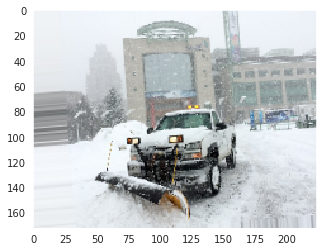

SNOWY


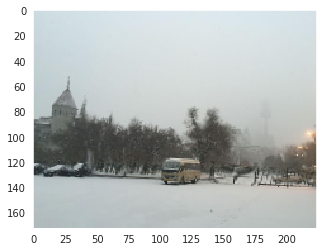

SNOWY


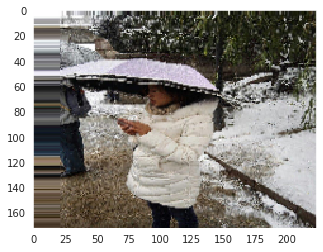

In [0]:
n = 3
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()

# Custom CNN

## AndreaNet

This is my custom made Convolutional Neural Network. I heavily drew inspiration from AlexNet, and tweaked several features:
- I added a convolutional layer
- I modified the number and size of kernels in each layer
- I added maxPooling between each convolutional layer, and added an averagePooling before the last Flatten layer, as an attempt on having a better classification done by the dense layers

In [0]:
def AndreaNet(input_shape, num_classes, lr=0.0001, regl2=0.0001, dropout=0.5):

    model = Sequential()

    # C1 Convolutional Layer 
    model.add(Conv2D(filters=256, input_shape=input_shape, kernel_size=(1,1), strides=(1,1), padding='valid'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Activation
    model.add(Activation('relu'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='valid'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Activation
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C3 Convolutional Layer
    model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=(1,1), padding='valid'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Activation
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C4 Convolutional Layer
    model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=(1,1), padding='valid'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Activation
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C5 Convolutional Layer
    model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='valid'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Activation
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # C6 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='valid'))
    # Pooling
    model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Activation
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())
    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)
    
    # D1 Dense Layer
    model.add(Dense(4096, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(dropout))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D2 Dense Layer
    model.add(Dense(2048, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(dropout))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D3 Dense Layer
    model.add(Dense(1024,kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(dropout))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile

    adam = optimizers.Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [0]:
model_name = "AndreaNet_MWI_100epochs"

# # create the model
# model = AndreaNet(input_shape,num_classes)

# load the model
model = loadmodel(homework_folder, model_name)

# model.summary()


Model loaded successfully from file ./drive/My Drive/Colab Notebooks (1)/ML_HW2/andrea/AndreaNet_MWI_100epochs.h5



### Training

In [0]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

try:
    history = model.fit_generator(train_generator, epochs=100, verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_generator,
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/100
100/100 [==============================] - 163s 2s/step - loss: 1.8046 - accuracy: 0.5362 - val_loss: 0.8184 - val_accuracy: 0.2788
Epoch 2/100
100/100 [==============================] - 144s 1s/step - loss: 1.4985 - accuracy: 0.6391 - val_loss: 0.5733 - val_accuracy: 0.2788
Epoch 3/100
100/100 [==============================] - 143s 1s/step - loss: 1.4495 - accuracy: 0.6750 - val_loss: 0.6262 - val_accuracy: 0.3594
Epoch 4/100
100/100 [==============================] - 144s 1s/step - loss: 1.3970 - accuracy: 0.6900 - val_loss: 0.5399 - val_accuracy: 0.4651
Epoch 5/100
100/100 [==============================] - 143s 1s/step - loss: 1.3819 - accuracy: 0.6959 - val_loss: 0.7814 - val_accuracy: 0.6683
Epoch 6/100
100/100 [==============================] - 145s 1s/step - loss: 1.3481 - accuracy: 0.6969 - val_loss: 0.7889 - val_accuracy: 0.7067
Epoch 7/100
100/100 [==============================] - 144s 1s/step - loss: 1.2909 - accuracy: 0.7256 - val_loss: 1.2601 - val_accuracy:

Saving model.

In [0]:
savemodel(homework_folder, model, model_name)


Model saved successfully on file ./drive/My Drive/Colab Notebooks (1)/ML_HW2/andrea/AndreaNet_MWI_100epochs.h5



### Evaluation

In [0]:
test_generator = image_generator.flow_from_directory(
    directory=dataset_path,
    subset="validation",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

val_steps=test_generator.n//test_generator.batch_size

Found 800 images belonging to 4 classes.


Classification report.

In [0]:
preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

y_pred = np.argmax(preds, axis=1)
y_test = test_generator.classes 

print(classification_report(y_test, y_pred, labels=None, target_names=classnames, digits=3))

25/25 [==============================] - 14s 557ms/step
              precision    recall  f1-score   support

        HAZE      0.784     0.905     0.840       200
       RAINY      0.751     0.845     0.795       200
       SNOWY      0.893     0.625     0.735       200
       SUNNY      0.917     0.935     0.926       200

    accuracy                          0.828       800
   macro avg      0.836     0.828     0.824       800
weighted avg      0.836     0.828     0.824       800



Confusion report.

In [0]:
confusion_report(y_test, y_pred, classnames, test_generator.n)

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
SNOWY            ->  RAINY             	44 	5.50 % 
SNOWY            ->  HAZE              	27 	3.38 % 
RAINY            ->  HAZE              	16 	2.00 % 
RAINY            ->  SNOWY             	9 	1.12 % 
HAZE             ->  RAINY             	7 	0.88 % 
HAZE             ->  SUNNY             	7 	0.88 % 
SUNNY            ->  HAZE              	7 	0.88 % 
RAINY            ->  SUNNY             	6 	0.75 % 
HAZE             ->  SNOWY             	5 	0.62 % 
SUNNY            ->  RAINY             	5 	0.62 % 
SNOWY            ->  SUNNY             	4 	0.50 % 
SUNNY            ->  SNOWY             	1 	0.12 % 


Plot results.

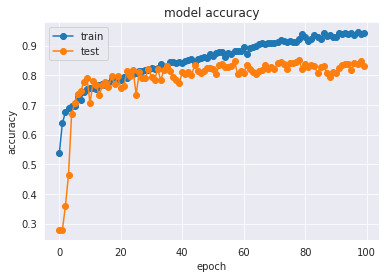

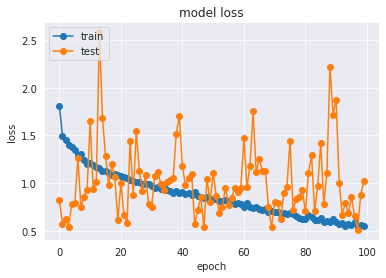

In [0]:
plot_training_history(history)

Plot predictions on some random samples of test.

In [0]:
test_generator = image_generator.flow_from_directory(
    directory=dataset_path,
    subset="validation",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

X_test, y_test = next(test_generator)
y_pred = model.predict(X_test)

Found 800 images belonging to 4 classes.


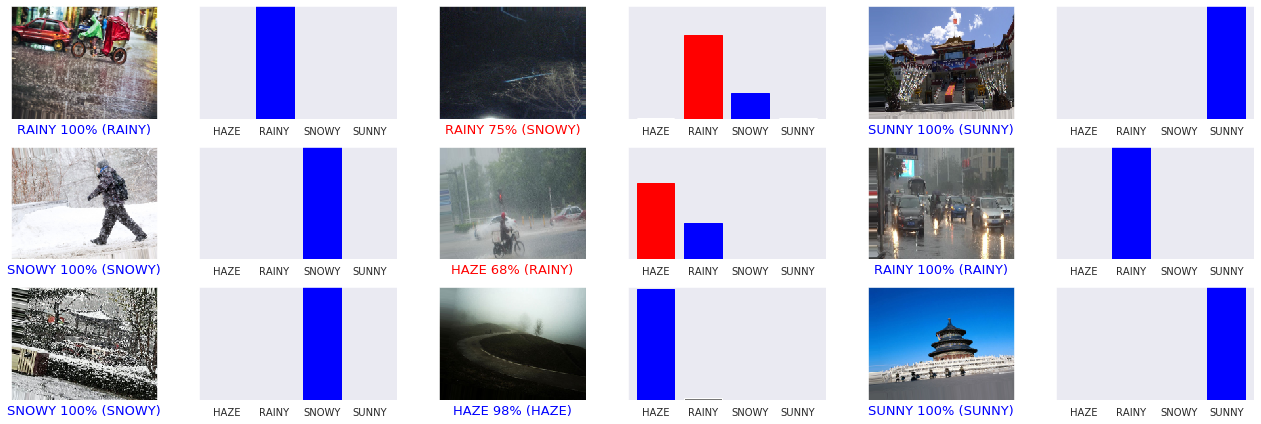

In [0]:
plot_examples(X_test, y_test, y_pred, classnames)

Plot some random misclassified examples

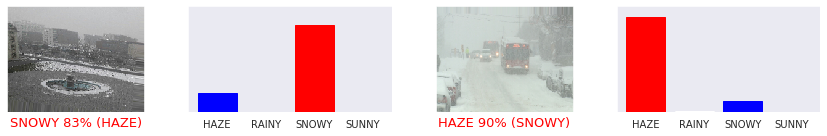

In [0]:
X_test, y_test = next(test_generator)
y_pred = model.predict(X_test)

plot_misclassified_examples(X_test, y_test, y_pred, classnames)

# Transfer Learning

Here I took a base model, with its weights already set from a previously done training, and used it in two different ways:
- as the starting point of a FNN, relying on the vectors computed by the base model followed by a Flatten layer
- as a feature extractor for a (not NN) machine learning model

## TL Network

Here I follow the first approach. This model will take in a base, pre-trained model, and attach to it a Flatten layer, followed by two Dense layers, of moderate size, otherwise the number of parameters to be trained grows sharply, making the whole process of transfer learning pointless. At the end, we have an output layer with the desired number of output neurons that corresponds to the number of classes of the problem at hand, which in this case is 4.

In [0]:
def build_model_from_pre_trained(pre_trained_model, input_shape, num_classes, regl2=0.0001):
  model = Sequential()
  model.add(pre_trained_model)
  model.add(Flatten()) # obtain a single vector out of the output of the network
  model.add(BatchNormalization())

  flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)
  # D1 Dense Layer
  model.add(Dense(256, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
  model.add(Activation('relu'))
  # Dropout
  model.add(Dropout(0.5))
  # Batch Normalisation
  model.add(BatchNormalization())

  # D2 Dense Layer
  model.add(Dense(128,kernel_regularizer=regularizers.l2(regl2)))
  model.add(Activation('relu'))
  # Dropout
  model.add(Dropout(0.5))
  # Batch Normalisation
  model.add(BatchNormalization())

  # Output Layer
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
  return model

Here I try out this approach with two different CNNs taken from the library _Keras_.

### VGG

In [0]:
base_model = applications.vgg16.VGG16(weights="imagenet", 
                               include_top=False,
                               input_shape=input_shape)

base_model.trainable = False
# base_model.summary()

58892288/58889256 [==============================] - 23s 0us/step


Building a model on top of the pretrained vgg16 network, with all the params set to non-trainable, with just a final output classifying layer.

In [0]:
tl_model_name = "TL_vgg_MWI_100epochs_2dense_256-128"
# build model
tl_model = build_model_from_pre_trained(base_model, input_shape, num_classes)

# # load model
# tl_model = loadmodel(homework_folder, tl_model_name)
tl_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 17920)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 17920)             71680     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4587776   
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)              

#### Training

In [0]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

try:
    tl_history = tl_model.fit_generator(train_generator, epochs=100, verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_generator,
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/100
100/100 [==============================] - 1184s 12s/step - loss: 1.0146 - accuracy: 0.6581 - val_loss: 1.1193 - val_accuracy: 0.7188
Epoch 2/100
100/100 [==============================] - 64s 638ms/step - loss: 0.8180 - accuracy: 0.7287 - val_loss: 0.5611 - val_accuracy: 0.7993
Epoch 3/100
100/100 [==============================] - 64s 643ms/step - loss: 0.7423 - accuracy: 0.7603 - val_loss: 0.4636 - val_accuracy: 0.8365
Epoch 4/100
100/100 [==============================] - 64s 643ms/step - loss: 0.6815 - accuracy: 0.7922 - val_loss: 0.9390 - val_accuracy: 0.8161
Epoch 5/100
100/100 [==============================] - 64s 636ms/step - loss: 0.6467 - accuracy: 0.8059 - val_loss: 0.6459 - val_accuracy: 0.8125
Epoch 6/100
100/100 [==============================] - 64s 639ms/step - loss: 0.6143 - accuracy: 0.8278 - val_loss: 0.4999 - val_accuracy: 0.8089
Epoch 7/100
100/100 [==============================] - 63s 635ms/step - loss: 0.6011 - accuracy: 0.8328 - val_loss: 0.7980 -

In [0]:
savemodel(homework_folder, tl_model, tl_model_name)


Model saved successfully on file ./drive/My Drive/Colab Notebooks (1)/ML_HW2/andrea/TL_vgg_MWI_100epochs_2dense_256-128.h5



#### Evaluation

In [0]:
test_generator = image_generator.flow_from_directory(
    directory=dataset_path,
    subset="validation",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

val_steps=test_generator.n//test_generator.batch_size+1

Found 800 images belonging to 4 classes.


Classification report.

In [0]:
preds = tl_model.predict_generator(test_generator,verbose=1,steps=val_steps)

y_pred = np.argmax(preds, axis=1)
y_test = test_generator.classes  
print(classification_report(y_test, y_pred, labels=None, target_names=classnames, digits=3))

25/25 [==============================] - 15s 581ms/step
              precision    recall  f1-score   support

        HAZE      0.871     0.845     0.858       200
       RAINY      0.813     0.870     0.841       200
       SNOWY      0.800     0.780     0.790       200
       SUNNY      0.919     0.905     0.912       200

    accuracy                          0.850       800
   macro avg      0.851     0.850     0.850       800
weighted avg      0.851     0.850     0.850       800



Confusion report.

In [0]:
confusion_report(y_test, y_pred, classnames, test_generator.n)

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
SNOWY            ->  RAINY             	27 	3.38 % 
RAINY            ->  SNOWY             	17 	2.12 % 
HAZE             ->  SNOWY             	15 	1.88 % 
SNOWY            ->  HAZE              	12 	1.50 % 
HAZE             ->  RAINY             	10 	1.25 % 
SUNNY            ->  HAZE              	9 	1.12 % 
SUNNY            ->  SNOWY             	7 	0.88 % 
HAZE             ->  SUNNY             	6 	0.75 % 
RAINY            ->  SUNNY             	5 	0.62 % 
SNOWY            ->  SUNNY             	5 	0.62 % 
RAINY            ->  HAZE              	4 	0.50 % 
SUNNY            ->  RAINY             	3 	0.38 % 


Plot results.

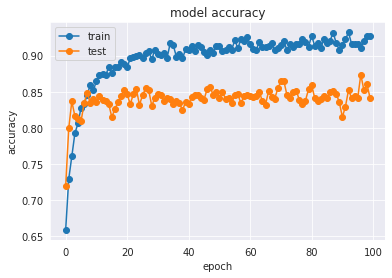

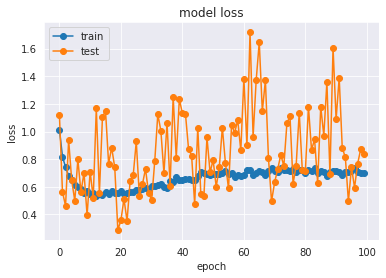

In [0]:
plot_training_history(tl_history)

Plot predictions on some random samples of test.

In [0]:
test_generator = image_generator.flow_from_directory(
    directory=dataset_path,
    subset="validation",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

Found 800 images belonging to 4 classes.


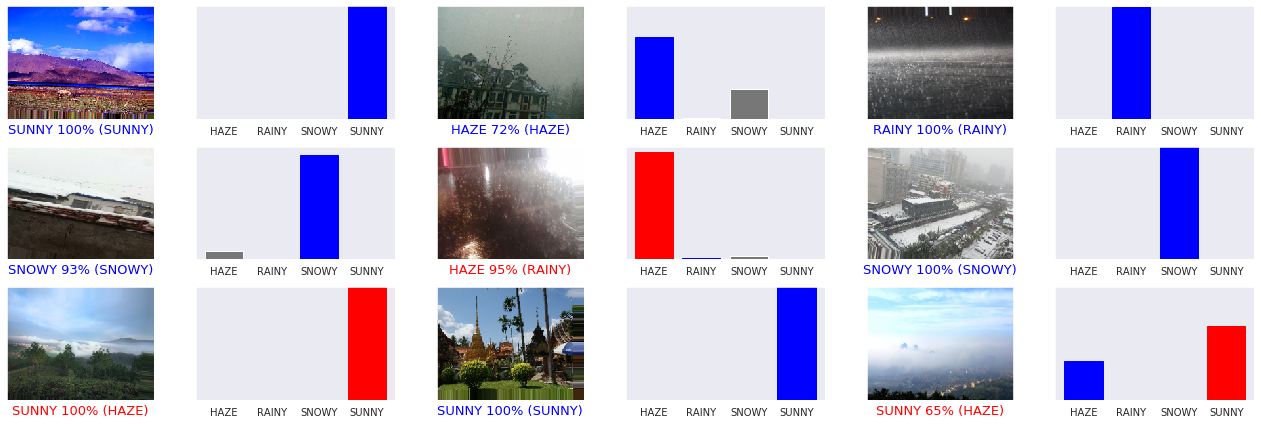

In [0]:
X_test, y_test = next(test_generator)
y_pred = tl_model.predict(X_test)

plot_examples(X_test, y_test, y_pred, classnames)

Plot some random misclassified examples

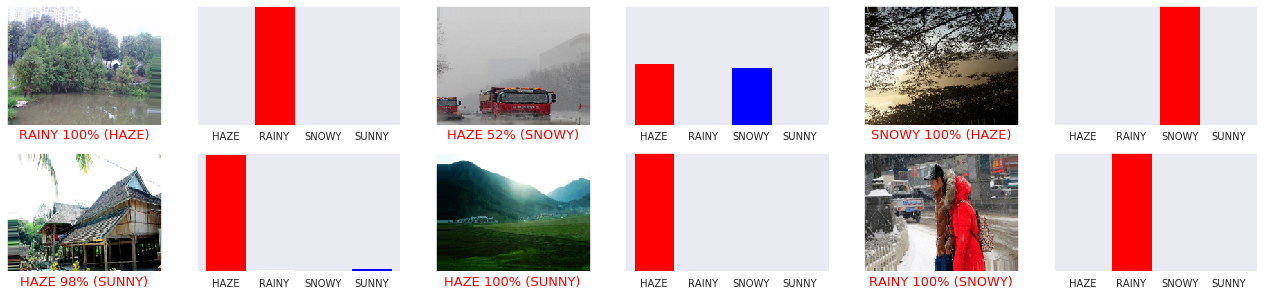

In [0]:
X_test, y_test = next(test_generator)
y_pred = tl_model.predict(X_test)

plot_misclassified_examples(X_test, y_test, y_pred, classnames)

### InceptionResNetV2

In [0]:
base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(weights="imagenet", 
                                               include_top=False,
                                               input_shape=input_shape)

base_model.trainable = False
# base_model.summary()

219062272/219055592 [==============================] - 4s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 172, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 85, 111, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 85, 111, 32)  96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 85, 111, 32)  0           batch_normalization_1[0][0]      
_____________

Building a custom model on top of the pretrained resnet network, with all the params set to non-trainable.

In [0]:
tl_model_name = "TL_resnet_MWI_100epochs_2dense_256-128"

# build model
# tl_model = build_model_from_pre_trained(base_model, input_shape, num_classes)

# # load model
tl_model = loadmodel(homework_folder, tl_model_name)

# tl_model.summary()

#### Training

In [0]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=10)]

try:
    tl_history = tl_model.fit_generator(train_generator, epochs=100, verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_generator,
                    validation_steps=val_steps,
                    callbacks=callbacks)
except KeyboardInterrupt:
    pass

Epoch 1/100
100/100 [==============================] - 1036s 10s/step - loss: 1.3994 - accuracy: 0.4872 - val_loss: 3.2636 - val_accuracy: 0.6010
Epoch 2/100
100/100 [==============================] - 74s 736ms/step - loss: 1.0915 - accuracy: 0.6253 - val_loss: 2.7375 - val_accuracy: 0.6058
Epoch 3/100
100/100 [==============================] - 73s 729ms/step - loss: 0.9475 - accuracy: 0.6866 - val_loss: 2.0702 - val_accuracy: 0.6911
Epoch 4/100
100/100 [==============================] - 73s 726ms/step - loss: 0.8902 - accuracy: 0.7194 - val_loss: 1.8053 - val_accuracy: 0.7139
Epoch 5/100
100/100 [==============================] - 73s 730ms/step - loss: 0.8313 - accuracy: 0.7563 - val_loss: 1.6947 - val_accuracy: 0.7392
Epoch 6/100
100/100 [==============================] - 72s 725ms/step - loss: 0.8265 - accuracy: 0.7622 - val_loss: 0.9502 - val_accuracy: 0.7476
Epoch 7/100
100/100 [==============================] - 73s 725ms/step - loss: 0.8188 - accuracy: 0.7653 - val_loss: 1.2702 -

In [0]:
savemodel(homework_folder, tl_model, tl_model_name)


Model saved successfully on file ./drive/My Drive/Colab Notebooks (1)/ML_HW2/andrea/TL_resnet_MWI_100epochs_2dense_256-128.h5



#### Evaluation

In [0]:
test_generator = image_generator.flow_from_directory(
    directory=dataset_path,
    subset="validation",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

val_steps=test_generator.n//test_generator.batch_size

Found 800 images belonging to 4 classes.


Classification report.

In [0]:
preds = tl_model.predict_generator(test_generator,verbose=1,steps=val_steps)

y_pred = np.argmax(preds, axis=1)
y_test = test_generator.classes  

print(classification_report(y_test, y_pred, labels=None, target_names=classnames, digits=3))

25/25 [==============================] - 17s 673ms/step
              precision    recall  f1-score   support

        HAZE      0.771     0.655     0.708       200
       RAINY      0.852     0.750     0.798       200
       SNOWY      0.730     0.730     0.730       200
       SUNNY      0.697     0.885     0.780       200

    accuracy                          0.755       800
   macro avg      0.762     0.755     0.754       800
weighted avg      0.762     0.755     0.754       800



Confusion report.

In [0]:
confusion_report(y_test, y_pred, classnames, test_generator.n)

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
HAZE             ->  SUNNY             	43 	5.38 % 
RAINY            ->  SNOWY             	30 	3.75 % 
SNOWY            ->  SUNNY             	21 	2.62 % 
HAZE             ->  SNOWY             	19 	2.38 % 
SNOWY            ->  HAZE              	18 	2.25 % 
SNOWY            ->  RAINY             	15 	1.88 % 
SUNNY            ->  HAZE              	14 	1.75 % 
RAINY            ->  SUNNY             	13 	1.62 % 
HAZE             ->  RAINY             	7 	0.88 % 
RAINY            ->  HAZE              	7 	0.88 % 
SUNNY            ->  SNOWY             	5 	0.62 % 
SUNNY            ->  RAINY             	4 	0.50 % 


Plot results.

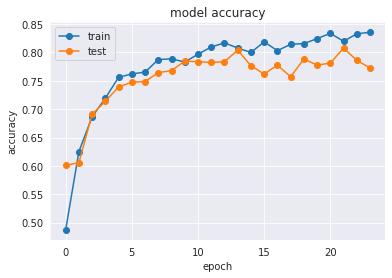

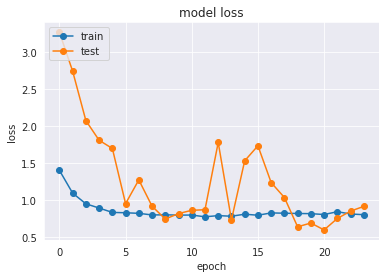

In [0]:
plot_training_history(tl_history)

Plot predictions on some random samples of test.

In [0]:
test_generator = image_generator.flow_from_directory(
    directory=dataset_path,
    subset="validation",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

Found 800 images belonging to 4 classes.


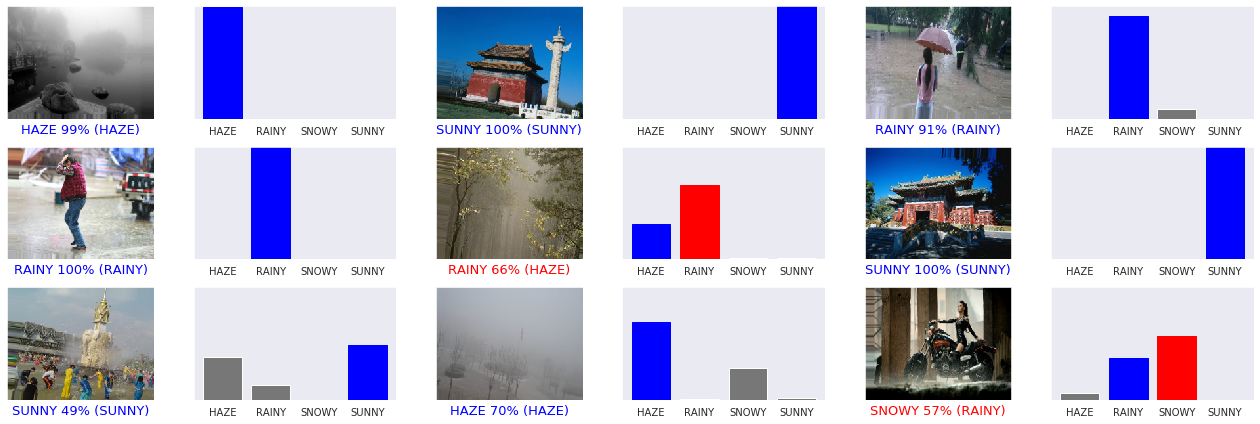

In [0]:
X_test, y_test = next(test_generator)
y_pred = tl_model.predict(X_test)

plot_examples(X_test, y_test, y_pred, classnames)

Plot some random misclassified examples

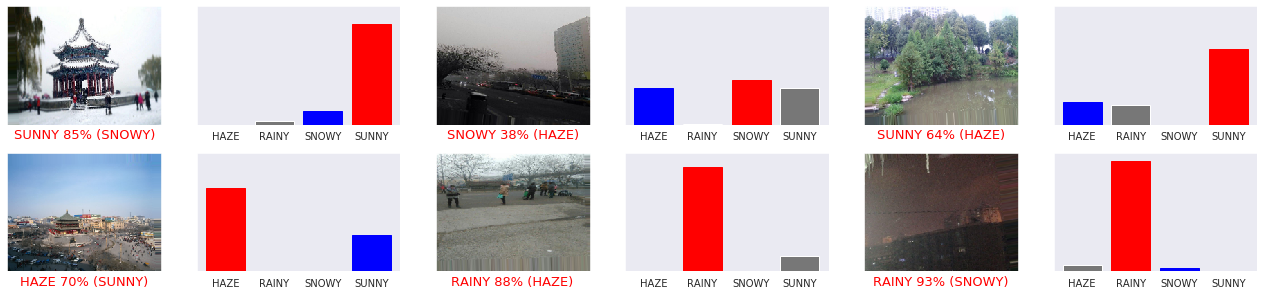

In [0]:
X_test, y_test = next(test_generator)
y_pred = tl_model.predict(X_test)

plot_misclassified_examples(X_test, y_test, y_pred, classnames)

## TL as a feature extractor

Here I try out the second approach.

In [0]:
def feature_extractor(pre_trained_model, input_shape):
  model = Sequential()
  model.add(pre_trained_model)
  model.add(BatchNormalization())
  model.add(Flatten())
  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
  return model

I need a new imagedatagenerator, that will transform the whole dataset, which will be fed to a pre-trained CNN to obtain feature vectors (its "predictions").

In [0]:
batch_size = 32
target_size = (172,224)
image_generator = ImageDataGenerator(
    rescale = 1. / 255,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

I make this experiment with the same two networks used in the previous approach, using their predictions to train and evaluate two linear models: SVM and Logistic Regression.

### VGG

In [0]:
base_model_name = "vgg"
base_model = applications.vgg16.VGG16(weights="imagenet", 
                               include_top=False,
                               input_shape=input_shape)

base_model.trainable = False
# base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200, 250, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 62, 128)       0     

#### Dataset building

In [0]:
feature_extractor = feature_extractor(base_model, input_shape)

tl_generator = image_generator.flow_from_directory(
    directory=dataset_path,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

print("Building set of feature vectors...")
val_steps=tl_generator.n//tl_generator.batch_size

features = feature_extractor.predict_generator(tl_generator,
                                        verbose=1,
                                        steps=val_steps)
labels = tl_generator.classes  
print("Done.")
print("Saving datasets for future use...")
np.save(homework_folder + "/features_{}".format(base_model_name), features)
np.save(homework_folder + "/labels_{}".format(base_model_name), labels)
print("Done.")

Found 4000 images belonging to 4 classes.
Building set of feature vectors...
125/125 [==============================] - 1201s 10s/step
Done.
Saving datasets for future use...
Done.


In [0]:
features = np.load(homework_folder + "/features_{}.npy".format(base_model_name))
labels = np.load(homework_folder + "/labels_{}.npy".format(base_model_name))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, labels , test_size=0.2)

In [0]:
print("Training set shape: {} - {}".format(X_train.shape, y_train.shape))
print("Test set shape: {} - {}".format(X_test.shape, y_test.shape))

Training set shape: (3200, 21504) - (3200,)
Test set shape: (800, 21504) - (800,)


#### SVM

##### Training

In [0]:
svm_model = SVC()

params = [
        {
            "kernel": ["linear"],
            "C": [1]
        }
    ]

clf = GridSearchCV(svm_model, params, cv=4, n_jobs=-1, verbose=1)

print("Fitting model...")
start_time = datetime.now()
clf.fit(X_train, y_train)
elapsed_time = datetime.now() - start_time
print("Done. (%s)" % (str(elapsed_time)))

Fitting model...
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  8.1min finished


Done. (0:11:18.088254)

Best parameters set:
{'C': 1, 'kernel': 'linear'}


In [0]:
print("Computing predictions...")
start_time = datetime.now()
y_preds = clf.predict(X_test)
elapsed_time = datetime.now() - start_time
print("Done. (%s)" % (str(elapsed_time)))

Computing predictions...
Done. (0:00:47.629502)


##### Evaluation

In [0]:
print(classification_report(y_test, y_preds, labels=None, target_names=classnames, digits=3))

              precision    recall  f1-score   support

        HAZE      0.791     0.861     0.825       194
       RAINY      0.780     0.792     0.786       197
       SNOWY      0.737     0.667     0.700       198
       SUNNY      0.895     0.891     0.893       211

    accuracy                          0.804       800
   macro avg      0.801     0.803     0.801       800
weighted avg      0.803     0.804     0.802       800



In [0]:
joblib.dump(clf.best_estimator_, homework_folder + "/svm_vgg")

['./drive/My Drive/Colab Notebooks (1)/ML_HW2/andrea/svm_vgg']

#### LogisticRegression

##### Training

In [0]:
lr_model = LogisticRegression()

params = [
        {
            "C": [1],
            "max_iter": [1000]
        }
    ]

clf = GridSearchCV(lr_model, params, cv=4, n_jobs=-1, verbose=1)

print("Fitting model...")
start_time = datetime.now()
clf.fit(X_train, y_train)
elapsed_time = datetime.now() - start_time
print("Done. (%s)" % (str(elapsed_time)))

Fitting model...
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.7min finished


Done. (0:02:26.519856)

Best parameters set:
{'C': 1}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
print("Computing predictions...")
start_time = datetime.now()
y_preds = clf.predict(X_test)
elapsed_time = datetime.now() - start_time
print("Done. (%s)" % (str(elapsed_time)))

Computing predictions...
Done. (0:00:00.127523)


##### Evaluation

In [0]:
print(classification_report(y_test, y_preds, labels=None, target_names=classnames, digits=3))

              precision    recall  f1-score   support

        HAZE      0.820     0.866     0.842       194
       RAINY      0.790     0.822     0.806       197
       SNOWY      0.790     0.702     0.743       198
       SUNNY      0.893     0.905     0.899       211

    accuracy                          0.825       800
   macro avg      0.823     0.824     0.823       800
weighted avg      0.824     0.825     0.824       800



In [0]:
joblib.dump(clf.best_estimator_, homework_folder + "/lr_vgg")

['./drive/My Drive/Colab Notebooks (1)/ML_HW2/andrea/lr_vgg']

### InceptionResNetV2

In [0]:
base_model_name = "resnet"
base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(weights="imagenet", 
                                               include_top=False,
                                               input_shape=input_shape)

base_model.trainable = False
# base_model.summary()

219062272/219055592 [==============================] - 8s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 200, 250, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 99, 124, 32)  864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 99, 124, 32)  96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 99, 124, 32)  0           batch_normalization_3[0][0]      
_____________

#### Dataset building

In [0]:
feature_extractor = feature_extractor(base_model, input_shape)

tl_generator = image_generator.flow_from_directory(
    directory=dataset_path,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

print("Building set of feature vectors...")
val_steps=tl_generator.n//tl_generator.batch_size

features = feature_extractor.predict_generator(tl_generator,
                                        verbose=1,
                                        steps=val_steps)
labels = tl_generator.classes  
print("Done.")
print("Saving datasets for future use...")
np.save(homework_folder + "/features_{}".format(base_model_name), features)
np.save(homework_folder + "/labels_{}".format(base_model_name), labels)
print("Done.")

Found 4000 images belonging to 4 classes.
Building set of feature vectors...
125/125 [==============================] - 130s 1s/step
Done.
Saving datasets for future use...
Done.


In [0]:
features = np.load(homework_folder + "/features_{}.npy".format(base_model_name))
labels = np.load(homework_folder + "/labels_{}.npy".format(base_model_name))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, labels , test_size=0.2)

In [0]:
print("Training set shape: {} - {}".format(X_train.shape, y_train.shape))
print("Test set shape: {} - {}".format(X_test.shape, y_test.shape))

Training set shape: (3200, 36864) - (3200,)
Test set shape: (800, 36864) - (800,)


#### SVM

##### Training

In [0]:
svm_model = SVC()

params = [
        {
            "kernel": ["linear"],
            "C": [1]
        }
    ]

clf = GridSearchCV(svm_model, params, cv=4, n_jobs=-1, verbose=1)

print("Fitting model...")
start_time = datetime.now()
clf.fit(X_train, y_train)
elapsed_time = datetime.now() - start_time
print("Done. (%s)" % (str(elapsed_time)))

Fitting model...
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 15.7min finished


Done. (0:21:46.136560)

Best parameters set:
{'C': 1, 'kernel': 'linear'}


In [0]:
print("Computing predictions...")
start_time = datetime.now()
y_preds = clf.predict(X_test)
elapsed_time = datetime.now() - start_time
print("Done. (%s)" % (str(elapsed_time)))

Computing predictions...
Done. (0:01:29.047054)


##### Evaluation

In [0]:
print(classification_report(y_test, y_preds, labels=None, target_names=classnames, digits=3))

              precision    recall  f1-score   support

        HAZE      0.798     0.869     0.832       214
       RAINY      0.795     0.856     0.824       181
       SNOWY      0.856     0.782     0.817       206
       SUNNY      0.880     0.814     0.846       199

    accuracy                          0.830       800
   macro avg      0.832     0.830     0.830       800
weighted avg      0.833     0.830     0.830       800



In [0]:
joblib.dump(clf.best_estimator_, homework_folder + "/svm_resnet")

['./drive/My Drive/Colab Notebooks (1)/ML_HW2/andrea/svm_resnet']

#### LogisticRegression

##### Training

In [0]:
lr_model = LogisticRegression()

params = [
        {
            "C": [1],
            "max_iter": [1000]
        }
    ]

clf = GridSearchCV(lr_model, params, cv=4, n_jobs=-1, verbose=1)

print("Fitting model...")
start_time = datetime.now()
clf.fit(X_train, y_train)
elapsed_time = datetime.now() - start_time
print("Done. (%s)" % (str(elapsed_time)))

Fitting model...
Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 15.5min finished


Done. (0:19:41.753431)


In [0]:
print("Computing predictions...")
start_time = datetime.now()
y_preds = clf.predict(X_test)
elapsed_time = datetime.now() - start_time
print("Done. (%s)" % (str(elapsed_time)))

Computing predictions...
Done. (0:00:00.209409)


##### Evaluation

In [0]:
print(classification_report(y_test, y_preds, labels=None, target_names=classnames, digits=3))

              precision    recall  f1-score   support

        HAZE      0.811     0.864     0.837       214
       RAINY      0.803     0.834     0.818       181
       SNOWY      0.861     0.782     0.819       206
       SUNNY      0.863     0.854     0.859       199

    accuracy                          0.834       800
   macro avg      0.835     0.834     0.833       800
weighted avg      0.835     0.834     0.834       800



In [0]:
joblib.dump(clf.best_estimator_, homework_folder + "/lr_resnet")

['./drive/My Drive/Colab Notebooks (1)/ML_HW2/andrea/lr_resnet']

# Evaluation on SMART-I test set

Here I evaluate the best model (according to cross-validation) trained on the MWI dataset, on the SMART-I dataset.

## Dataset

Loading dataset and building imagedatagenerators for training and validation.

In [0]:
!rm -rf "drive/My Drive/Colab Notebooks (1)/ML_HW2/datasets/Weather_Dataset/.ipynb_checkpoints"

In [0]:
testset_path = "drive/My Drive/Colab Notebooks (1)/ML_HW2/datasets/Weather_Dataset"

In [0]:
batch_size = 32
target_size = (172,224)

image_generator = ImageDataGenerator(
    rescale = 1. / 255,
    zoom_range=0,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split=None
)

testset_generator = image_generator.flow_from_directory(
    directory=testset_path,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

val_steps=testset_generator.n//testset_generator.batch_size+1

Found 3038 images belonging to 3 classes.


In [0]:
ts_num_samples = testset_generator.n
ts_num_classes = testset_generator.num_classes
ts_input_shape = testset_generator.image_shape

ts_classnames = [k for k,v in testset_generator.class_indices.items()]

print("Image input %s" %str(ts_input_shape))
print("Classes: %r" %ts_classnames)

print('Loaded %d training samples from %d classes.' %(ts_num_samples,ts_num_classes))
print('Loaded %d test samples from %d classes.' %(ts_num_samples,ts_num_classes))

Image input (172, 224, 3)
Classes: ['RAINY', 'SNOWY', 'SUNNY']
Loaded 3038 training samples from 3 classes.
Loaded 3038 test samples from 3 classes.


Implementing function to drop "HAZE" prediction, since this class is missing, and rescale all the other probabilities. 

In [0]:
def drop_haze_prediction(pred):
  # dropping haze
  new_pred = np.array(pred[1:])
  # rescaling
  new_pred *= (1./new_pred.sum())
  return new_pred

## Evaluation

Loading model.

In [0]:
model_name = "TL_vgg_MWI_100epochs_2dense_256-128"
model = loadmodel(homework_folder, model_name)


Model loaded successfully from file ./drive/My Drive/Colab Notebooks (1)/ML_HW2/andrea/TL_vgg_MWI_100epochs_2dense_256-128.h5



/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Classification report.

In [0]:
preds = model.predict_generator(testset_generator,verbose=1,steps=val_steps)
preds = np.apply_along_axis(drop_haze_prediction, 1, preds)
y_pred = np.argmax(preds, axis=1)

y_test = testset_generator.classes

95/95 [==============================] - 26s 277ms/step


In [0]:
print(classification_report(y_test, y_pred, labels=None, target_names=ts_classnames, digits=3))

              precision    recall  f1-score   support

       RAINY      0.381     0.814     0.519       521
       SNOWY      0.689     0.754     0.720      1421
       SUNNY      0.614     0.207     0.310      1096

    accuracy                          0.567      3038
   macro avg      0.561     0.592     0.516      3038
weighted avg      0.609     0.567     0.537      3038



We can see that the network gives very poor results, since the images provided by smart-I are very different from the images of the MWI dataset over which the network has been trained.

Confusion report.

In [0]:
confusion_report(y_test, y_pred, ts_classnames, testset_generator.n)

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
SUNNY            ->  RAINY             	461 	15.17 % 
SUNNY            ->  SNOWY             	408 	13.43 % 
SNOWY            ->  RAINY             	229 	7.54 % 
SNOWY            ->  SUNNY             	121 	3.98 % 
RAINY            ->  SNOWY             	75 	2.47 % 
RAINY            ->  SUNNY             	22 	0.72 % 


In [0]:
X_test, y_test = next(testset_generator)
y_pred = model.predict(X_test)
y_pred = np.apply_along_axis(drop_haze_prediction, 1, y_pred)

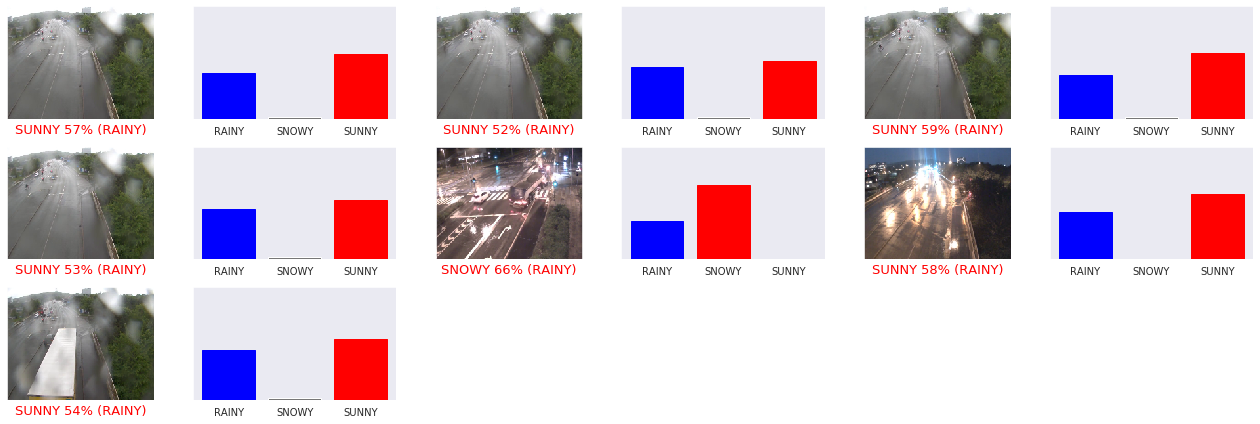

In [0]:
plot_misclassified_examples(X_test, y_test, y_pred, ts_classnames)

# Training on SMART-I dataset

Here I try to train the network directly on the smart-i dataset to see if better performances can be achieved.

## Image generators

In [0]:
testset_path = "drive/My Drive/Colab Notebooks (1)/ML_HW2/datasets/Weather_Dataset"

In [0]:
batch_size = 32
target_size = (172,224)
image_generator = ImageDataGenerator(
    rescale = 1. / 255,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.2
)

In [0]:
train_generator = image_generator.flow_from_directory(
    directory=testset_path,
    subset="training",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_generator = image_generator.flow_from_directory(
    directory=testset_path,
    subset="validation",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 2431 images belonging to 4 classes.
Found 607 images belonging to 4 classes.


In [0]:
num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))

Image input (172, 224, 3)
Classes: ['HAZE', 'RAINY', 'SNOWY', 'SUNNY']
Loaded 2431 training samples from 4 classes.
Loaded 607 test samples from 4 classes.


In [0]:
model_name = "AndreaNet_SMART-I_100epochs"

# create the model
model = AndreaNet(input_shape,num_classes)

# # load the model
# model = loadmodel(homework_folder, model_name)

# model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 172, 224, 256)     1024      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 86, 112, 256)      0         
_________________________________________________________________
activation_21 (Activation)   (None, 86, 112, 256)      0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 86, 112, 256)      1024      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 84, 110, 512)      1180160   
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 42, 55, 512)       0         
_________________________________________________________________
activation_22 (Activation)   (None, 42, 55, 512)      

## Training

In [0]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

callbacks = [EarlyStopping(monitor='val_accuracy', patience=10)]

try:
    history = model.fit_generator(train_generator, epochs=100, verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_generator,
                    validation_steps=val_steps,
                    callbacks=callbacks)
except KeyboardInterrupt:
    pass

Epoch 1/100
75/75 [==============================] - 49s 655ms/step - loss: 1.8253 - accuracy: 0.4548 - val_loss: 1.7782 - val_accuracy: 0.1713
Epoch 2/100
75/75 [==============================] - 49s 647ms/step - loss: 1.5721 - accuracy: 0.5807 - val_loss: 4.8801 - val_accuracy: 0.4679
Epoch 3/100
75/75 [==============================] - 48s 639ms/step - loss: 1.4864 - accuracy: 0.6419 - val_loss: 3.9721 - val_accuracy: 0.4448
Epoch 4/100
75/75 [==============================] - 48s 639ms/step - loss: 1.4013 - accuracy: 0.6765 - val_loss: 3.6389 - val_accuracy: 0.1960
Epoch 5/100
75/75 [==============================] - 47s 632ms/step - loss: 1.2870 - accuracy: 0.7125 - val_loss: 6.7560 - val_accuracy: 0.4778
Epoch 6/100
75/75 [==============================] - 48s 636ms/step - loss: 1.2957 - accuracy: 0.7068 - val_loss: 0.6581 - val_accuracy: 0.3839
Epoch 7/100
75/75 [==============================] - 47s 625ms/step - loss: 1.2534 - accuracy: 0.7378 - val_loss: 3.3800 - val_accuracy:

Saving model.

In [0]:
savemodel(homework_folder, model, model_name)


Model saved successfully on file ./drive/My Drive/Colab Notebooks (1)/ML_HW2/andrea/AndreaNet_SMART-I_100epochs.h5



## Evaluation

In [0]:
test_generator = image_generator.flow_from_directory(
    directory=testset_path,
    subset="validation",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

val_steps=test_generator.n//test_generator.batch_size+1

Found 607 images belonging to 3 classes.


Classification report.

In [0]:
preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

y_pred = np.argmax(preds, axis=1)
y_test = test_generator.classes  

print(classification_report(y_test, y_pred, labels=None, target_names=classnames, digits=3))

19/19 [==============================] - 10s 541ms/step
              precision    recall  f1-score   support

       rainy      0.439     1.000     0.610       104
       snowy      0.940     0.444     0.603       284
       sunny      0.873     0.941     0.905       219

    accuracy                          0.718       607
   macro avg      0.751     0.795     0.706       607
weighted avg      0.830     0.718     0.713       607



Confusion report.

In [0]:
confusion_report(y_test, y_pred, classnames, test_generator.n)

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
snowy            ->  rainy             	128 	21.09 % 
snowy            ->  sunny             	30 	4.94 % 
sunny            ->  snowy             	8 	1.32 % 
sunny            ->  rainy             	5 	0.82 % 


Plot results.

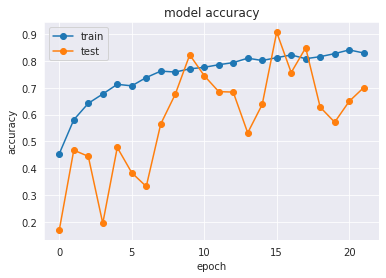

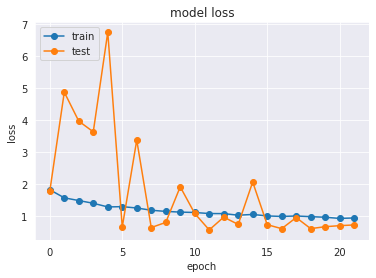

In [0]:
plot_training_history(history)

Plot predictions on some random samples of test.

In [0]:
test_generator = image_generator.flow_from_directory(
    directory=testset_path,
    subset="validation",
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

X_test, y_test = next(test_generator)
y_pred = model.predict(X_test)

Found 607 images belonging to 3 classes.


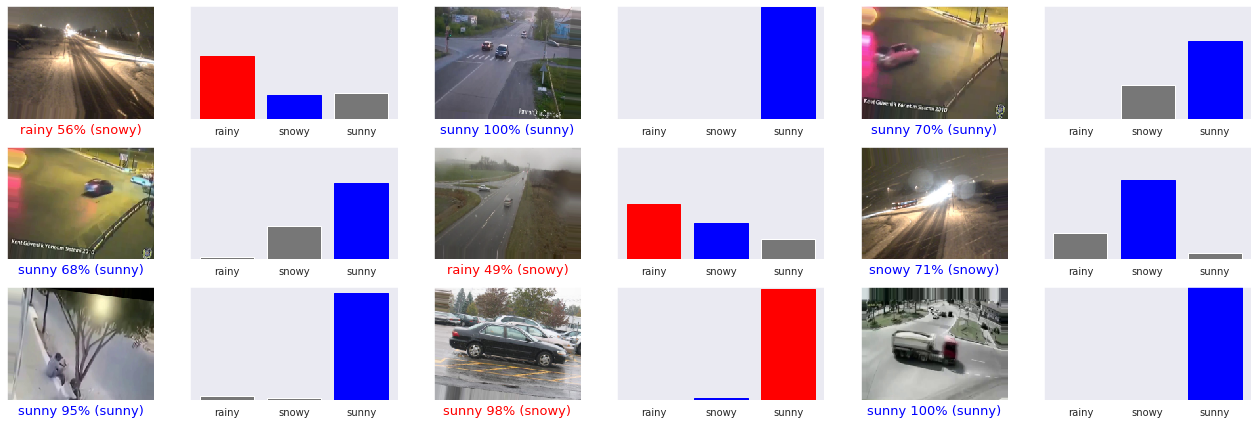

In [0]:
plot_examples(X_test, y_test, y_pred, classnames)

Plot some random misclassified examples

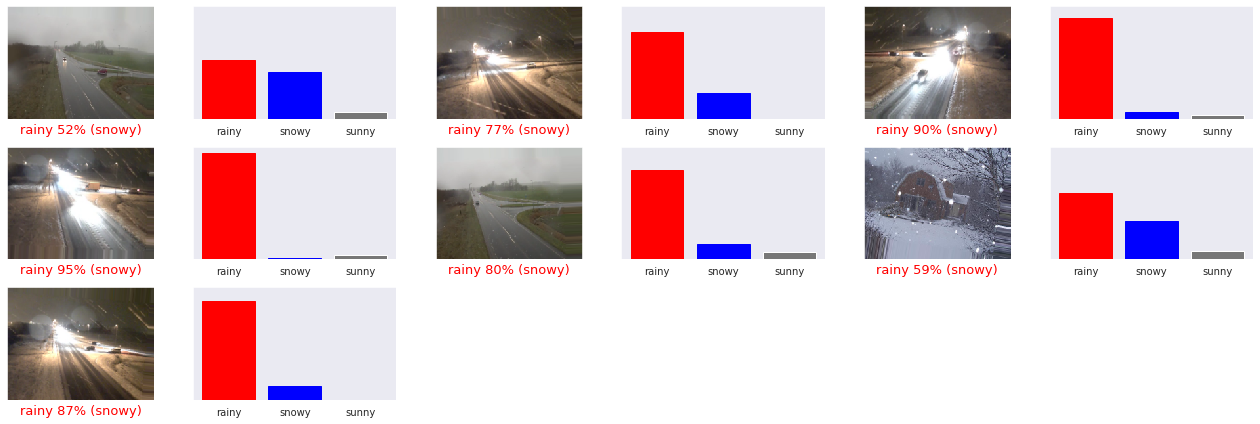

In [0]:
X_test, y_test = next(test_generator)
y_pred = model.predict(X_test)

plot_misclassified_examples(X_test, y_test, y_pred, classnames)

# Blind test set

This section contains code to make predictions on blind test set.

In [0]:
blind_dataset_path = dataset_folder + "/WeatherBlindTestSet"

## Exploring the dataset

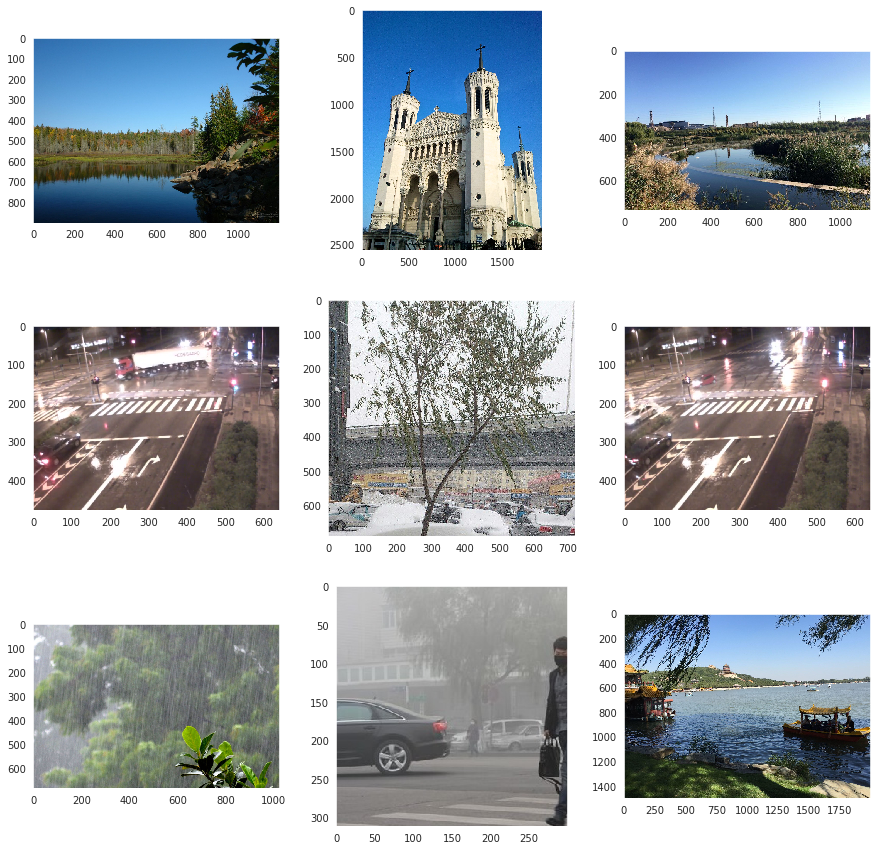

In [0]:
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15,15))
for i in range(num_rows):
  for j in range(num_cols):
    image = plt.imread(os.path.join(blind_dataset_path, random.choice(os.listdir(blind_dataset_path))))
    axs[i][j].imshow(image)

We can see that it has both images similar to the landascape-y ones from the MWI dataset and images similar to the CCTV of roads from the SMART-I dataset, with an abundance of the former with respect to the latter.

## Loading best model

In [0]:
# load best model
best_model_name = "TL_vgg_MWI_100epochs_2dense_256-128"
best_model = loadmodel(homework_folder, best_model_name)

second_best_model_name = "AndreaNet_MWI_100epochs"
second_best_model = loadmodel(homework_folder, second_best_model_name)

# # or load cnn feature extractor + linear model
# linear_model_name = "lr" # logistic regression
# cnn_name = "vgg" # cnn model used for feature extraction
# pre_trained_cnn = ...
# linear_model = joblib.load(homework_folder + "/{}_{}".format(linear_model_name, cnn_name))

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '



Model loaded successfully from file ./drive/My Drive/Colab Notebooks (1)/ML_HW2/andrea/TL_vgg_MWI_100epochs_2dense_256-128.h5


Model loaded successfully from file ./drive/My Drive/Colab Notebooks (1)/ML_HW2/andrea/AndreaNet_MWI_100epochs.h5



## Computing predictions

Loading images of blind test set.

Need to do a little trick in order to use generator: copy images into a subfolder (named 'None' in this case). Then the generator will load the images believing they belong to class 'None', but setting 'class_mode' to False will make it discard this information.

Building generators with no transformation of input images.

In [0]:
blindtestset_image_generator = ImageDataGenerator(
    rescale = 1. / 255,
    horizontal_flip=False,
    vertical_flip=False
)

prediction_generator = blindtestset_image_generator.flow_from_directory(
    directory=blind_dataset_path,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 1500 images belonging to 1 classes.


Making predictions and turning it from one-hot encoding to actual class labels.

In [0]:
val_steps = prediction_generator.n//batch_size+1
preds = best_model.predict_generator(prediction_generator,verbose=1,steps=val_steps)

predictions = []
for pred in preds:
  prediction_index = np.argmax(pred)
  predictions.append(classnames[prediction_index])

predictions = np.array(predictions)

47/47 [==============================] - 279s 6s/step


In [0]:
val_steps = prediction_generator.n//batch_size+1
preds_second = second_best_model.predict_generator(prediction_generator,verbose=1,steps=val_steps)

predictions_second = []
for pred in preds_second:
  prediction_index = np.argmax(pred)
  predictions_second.append(classnames[prediction_index])

predictions_second = np.array(predictions_second)

47/47 [==============================] - 28s 600ms/step


Using Pandas DataFrame in order to save to CSV file.

In [0]:
predictions_df = pd.DataFrame(data=predictions, columns=["prediction"])

In [0]:
predictions_second_df = pd.DataFrame(data=predictions_second, columns=["prediction"])

Saving predictions on a CSV file.

In [0]:
predictions_df.to_csv(homework_folder + "/blindtestset_predictions_tl_vgg_deeper.csv",
                      header=False,
                      index=False)

In [0]:
predictions_df.to_csv(homework_folder + "/blindtestset_predictions_andreanet.csv",
                      header=False,
                      index=False)

In [0]:
# predictions_df = pd.read_csv(homework_folder + "/blindtestset_predictions_MWI.csv", names=["prediction"])

## Exploring predictions

In [0]:
images = [os.path.join(blind_dataset_path, img_path) for img_path in sorted(os.listdir(blind_dataset_path))]

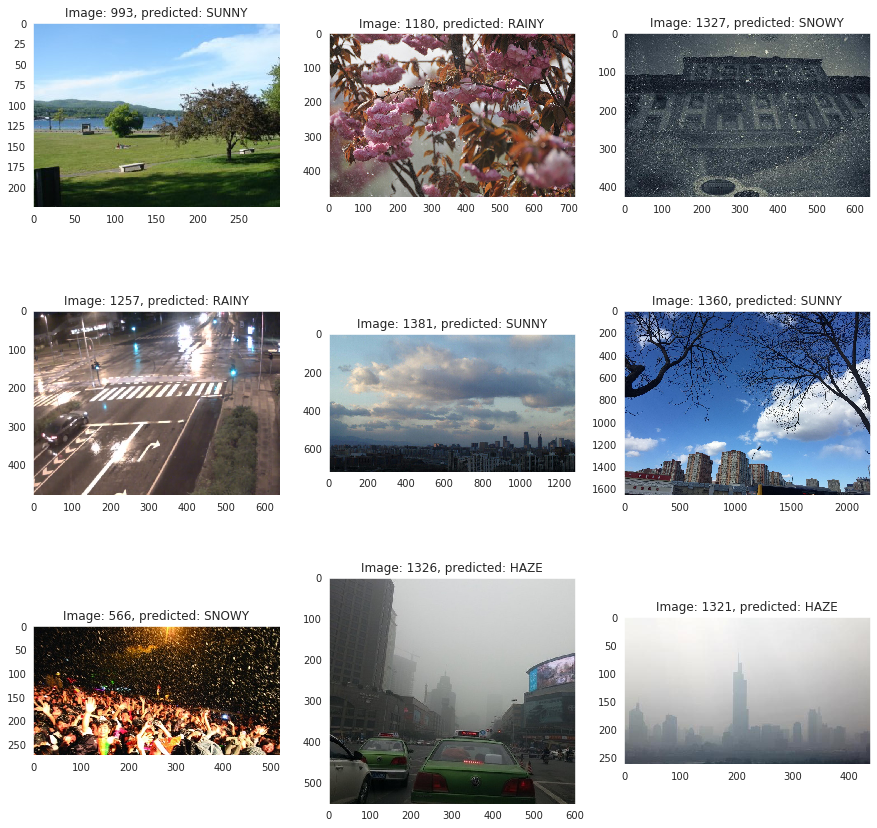

In [0]:
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15,15))
for i in range(num_rows):
  for j in range(num_cols):
    image_index = np.random.randint(0, len(os.listdir(blind_dataset_path)))
    # image_index = j + num_cols*i
    image = plt.imread(images[image_index])
    predicted_label = predictions_df["prediction"][image_index]
    axs[i][j].imshow(image)
    axs[i][j].set_title("Image: {}, predicted: {}".format(image_index, predicted_label))

Comparing predictions.

In [0]:
predictions_different = predictions_df != predictions_second_df

In [0]:
predictions_different[predictions_different["prediction"] == True].count()

prediction    353
dtype: int64

In [0]:
predictions_different_index = predictions_different[predictions_different["prediction"] == True].index
predictions_different_index

Int64Index([   4,    6,    7,    9,   11,   39,   43,   44,   45,   46,
            ...
            1455, 1462, 1464, 1466, 1467, 1468, 1474, 1476, 1479, 1496],
           dtype='int64', length=353)

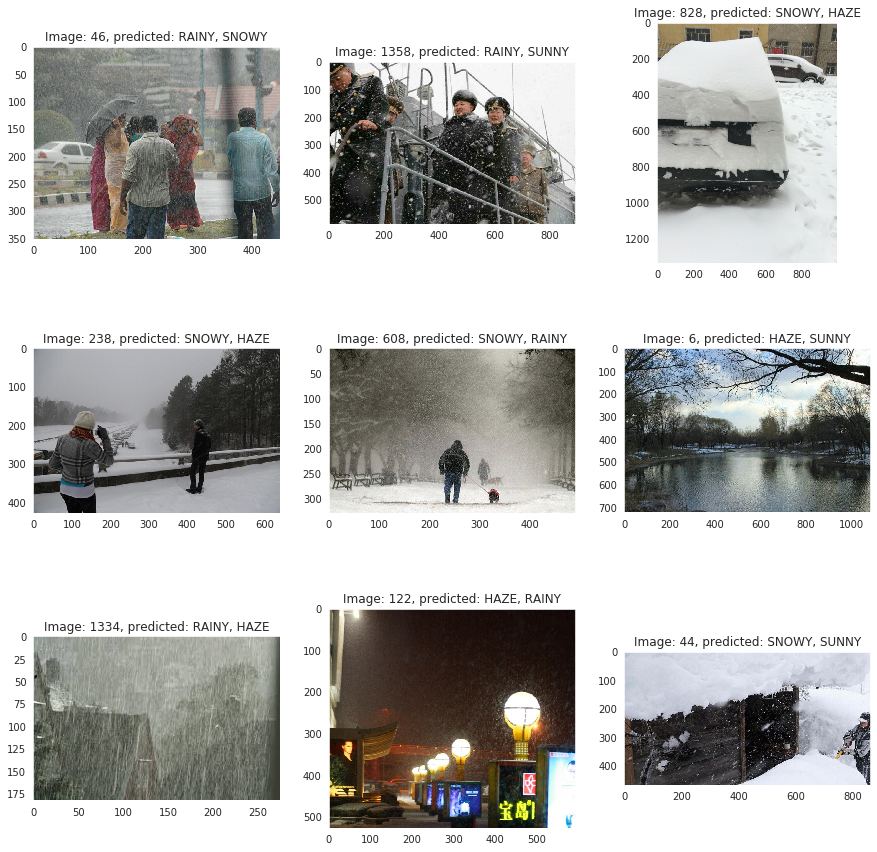

In [0]:
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15,15))
for i in range(num_rows):
  for j in range(num_cols):
    image_index = np.random.choice(predictions_different_index)
    image = plt.imread(images[image_index])
    predicted_label = predictions_df["prediction"][image_index]
    predicted_label_second = predictions_second_df["prediction"][image_index]
    axs[i][j].imshow(image)
    axs[i][j].set_title("Image: {}, predicted: {}, {}".format(image_index, predicted_label, predicted_label_second))